In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path
from superRes.metrics import *
from superRes.ssim import *
from superRes.fid_loss import *
from superRes.save import *
from superRes.loss import *
from superRes.dataset import *
from superRes.critics import *
from superRes.generators import *
from fastai.vision import *
from fastai import *

from datetime import datetime
import geffnet  # efficient/ mobile net

In [2]:
def do_fit(learn, epochs, save_name, lrs=slice(1e-3), pct_start=0.3):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save("/data/students_home/fmameli/repos/SuperRes/models/" + save_name)
    learn.show_results(rows=1, imgsize=5)

In [3]:
def get_video_data(pLow, pFull, bs: int, sz: int):
    src = ImageImageList.from_folder(pLow, presort=True).split_by_rand_pct(0.1)
    data = (src.label_from_func(lambda x: path_ori/(x.name.replace("_VHS", ""))).transform(
        get_transforms(
        ),
        size=sz,
        tfm_y=True,
    ).databunch(bs=bs, num_workers=8, no_check=True)
        .normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [4]:
path = Path('./dataset/')

path_vhs = path / "Apple_vhs_videos/"
path_ori = path / "Apple_original_videos/"

In [5]:
data = get_video_data(path_vhs, path_ori, 2, 512)

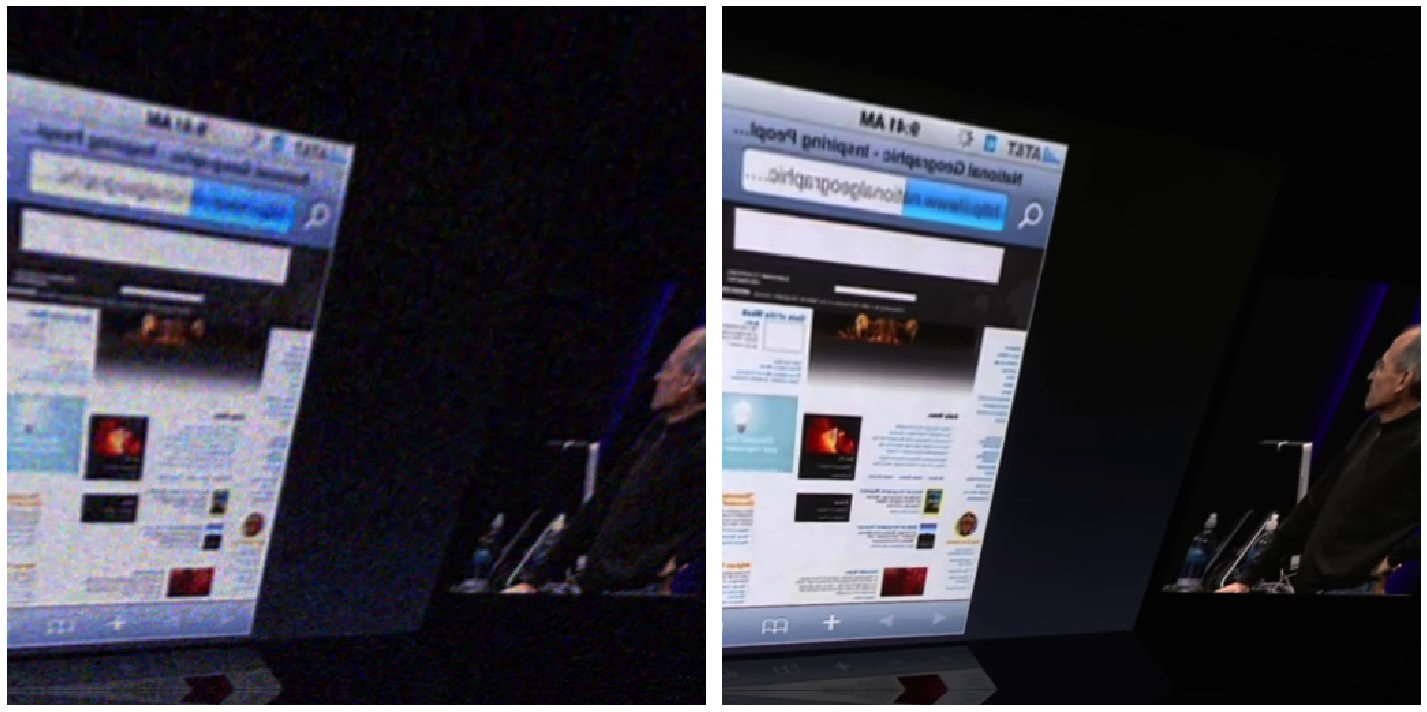

In [6]:
data.show_batch(rows=1, ds_type=DatasetType.Train, imgsize=10)

In [5]:
proj_id = 'unet_vhs_lpips'

gen_name = proj_id + '_gen'

In [6]:
model = geffnet.mobilenetv3_rw

loss_func = lpips_loss()

bs = 3
sz = 512
lr = 1e-3
wd = 1e-3
epochs = 1
nf_factor = 2

data_gen = get_video_data(path_vhs, path_ori, 2, sz)
print("Dataset loaded...")

learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch=model,
                             nf_factor=nf_factor)


learn_gen.metrics.append(SSIM_Metric_gen())
learn_gen.metrics.append(SSIM_Metric_input())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Dataset loaded...


In [9]:
data_gen

ImageDataBunch;

Train: LabelList (34263 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/Apple_vhs_videos;

Valid: LabelList (3806 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/Apple_vhs_videos;

Test: None

# Test

In [8]:
weights = "/data/students_home/fmameli/repos/SuperRes/models/unet_vhs_lpips_gen_0"
learn_gen.load(weights, with_opt=False)

Learner(data=ImageDataBunch;

Train: LabelList (34263 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/Apple_vhs_videos;

Valid: LabelList (3806 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/Apple_vhs_videos;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            

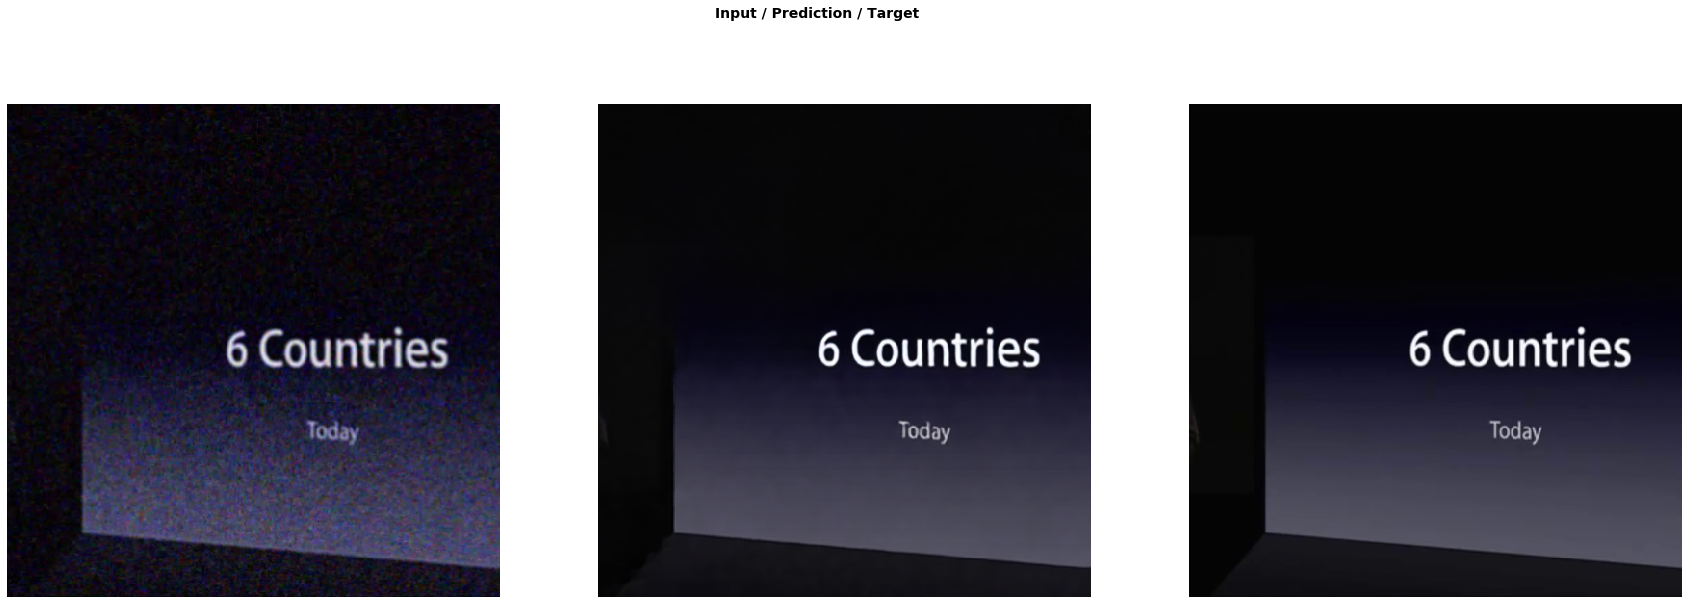

In [11]:
learn_gen.show_results(rows=1, imgsize=10)

In [17]:
data_gen = get_video_data(path_vhs, path_ori, 2, ( 404, 720))
learn_gen.data = data_gen

In [30]:
fn = data_gen.valid_dl.x.items[4]; fn

PosixPath('dataset/Apple_vhs_videos/Apple_WWDC_2008_iPhone_3G_Introduction_VHS_29267.jpg')

In [31]:
img = open_image(fn); print(img.shape)
p,img_hr,b = learn_gen.predict(img)

torch.Size([3, 404, 720])


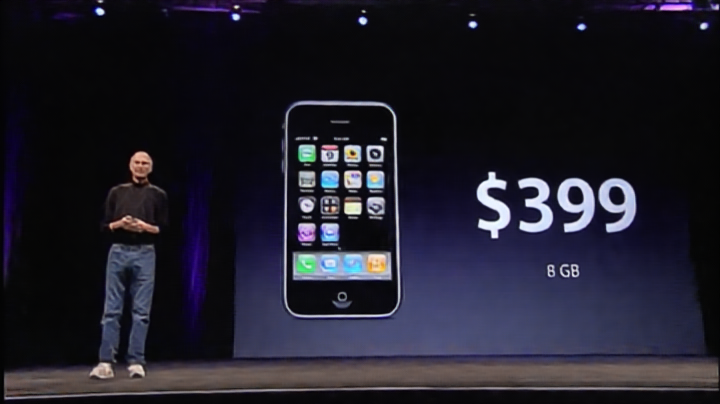

In [32]:
p

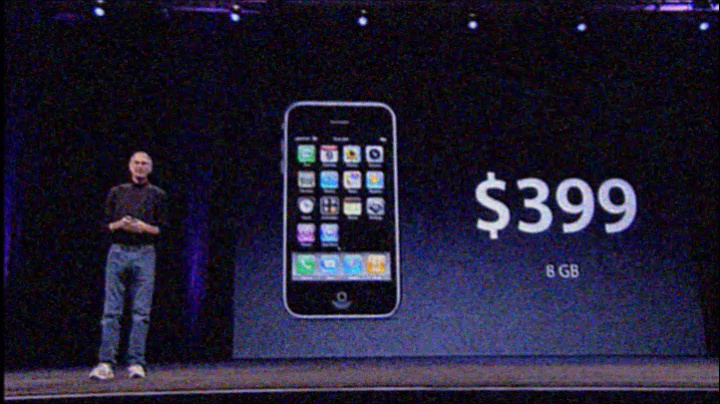

In [33]:
img